In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import datasets
from fusion.utils.eval import eval_on_dataset

MODEL_NAME = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_tokens(['zeroa', 'onea', 'synt'])

## Load datasets

In [2]:
op_train_data, op_synth_dev, op_orig_dev, op_synth_test, op_orig_test = datasets.load_from_disk('datasets/sst2_orderedpair').values()
st_train_data, st_synth_dev, st_orig_dev, st_synth_test, st_orig_test = datasets.load_from_disk('datasets/sst2_singletoken').values()
tic_train_data, tic_synth_dev, tic_orig_dev, tic_synth_test, tic_orig_test = datasets.load_from_disk('datasets/sst2_tokenincontext').values()
lt_train_data, lt_synth_dev, lt_orig_dev, lt_synth_test, lt_orig_test = datasets.load_from_disk('datasets/sst2_lasttoken').values()

## 2 Shared 1 Each

In [ ]:
from fusion.interpolate import interpolate_and_evaluate_2d
import pickle

model_paths = ['models/bert-base-cased-sst2-tic-op/checkpoint-8420', 'models/bert-base-cased-sst2-tic-or/checkpoint-8420']
dataset_paths = ['datasets/sst2_tokenincontext', 'datasets/sst2_orderedpair', 'datasets/sst2_or']
dataset_names = ['TiC', 'OP', 'OR']
model_names = ['TiC_OP', 'TiC_OR']
output_path = 'results/linear_interp_results_10_TiC-OP_TiC-OR_v2.pkl'
steps = 10

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
tokenizer.add_tokens(['zeroa', 'onea', 'synt'])

models = []
for model_name, path in zip(model_names, model_paths):
        model = AutoModelForSequenceClassification.from_pretrained(path)
        models.append(model)
results = interpolate_and_evaluate_2d('sst2', *models, tokenizer, dataset_paths, steps)


interp_eval_results = {}
for name, path in zip(dataset_names, dataset_paths):
    interp_eval_results[f"{name}_synth"] = results[path]['synthetic']
    interp_eval_results[f"{name}_orig"] = results[path]['original']


with open(output_path, 'wb') as f:
    pickle.dump(interp_eval_results, f)

In [23]:
import pickle
with open('results/linear_interp_results_10_TiC-OP_TiC-OR.pkl', 'rb') as f:
        results = pickle.load(f)

In [24]:
results.keys()

dict_keys(['TiC_synth', 'TiC_orig', 'OP_synth', 'OP_orig', 'OR_synth', 'OR_orig'])

In [25]:
tic_synth_results, tic_orig_results = results['TiC_synth'], results['TiC_orig']
op_synth_results, op_orig_results =  results['OP_synth'], results['OP_orig']
or_synth_results, or_orig_results = results['OR_synth'], results['OR_orig']

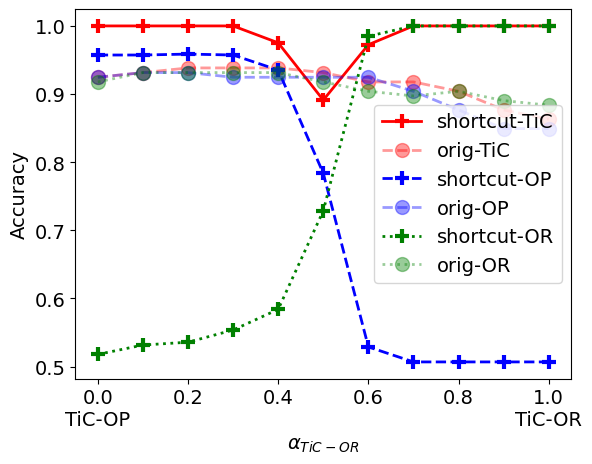

In [26]:
import matplotlib.pyplot as plt

steps = 10
coeffs = [i/steps for i in range(steps+1)]

plt.plot(coeffs, tic_synth_results, 'r+-', label='shortcut-TiC', linewidth=2.0, markersize=10, 
                 markeredgewidth=3.0)
plt.plot(coeffs, tic_orig_results, 'ro--', label='orig-TiC', linewidth=2.0, markersize=10, alpha=0.4)

plt.plot(coeffs, op_synth_results, 'b+--', label='shortcut-OP', linewidth=2.0, markersize=10, 
                 markeredgewidth=3.0)
plt.plot(coeffs, op_orig_results, 'bo--', label='orig-OP', linewidth=2.0, markersize=10, alpha=0.4)

plt.plot(coeffs, or_synth_results, 'g+:', label='shortcut-OR', linewidth=2.0, markersize=10, 
                 markeredgewidth=3.0)
plt.plot(coeffs, or_orig_results, 'go:', label='orig-OR', linewidth=2.0, markersize=10, alpha=0.4)

x_ticks = list(filter(lambda x: 0.0 <= x <= 1.0, map(lambda x: round(x, 2), plt.xticks()[0])))
tick_map = {'0.0': f'0.0\nTiC-OP', '1.0': f'1.0\nTiC-OR'}
xtick_labels = [tick_map[str(tick)] if str(tick) in tick_map else str(tick) for tick in x_ticks]

plt.xticks(ticks=x_ticks, labels=xtick_labels, fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel(f"$\\alpha_{{TiC-OR}}$", fontsize=14)
plt.ylabel(f"Accuracy", fontsize=14)

#plt.title(f'Interpolation TiC & OP \u2192 TiC & OR', fontsize=18)
plt.legend(loc="right", prop={'size': 14})

plt.savefig('results/interpolation_TiC-OP_TiC-OR.png', dpi=400, bbox_inches='tight')
plt.show()

## Random Directions

In [2]:
from transformers import AutoModelForSequenceClassification
from fusion.interpolate import interpolate_and_evaluate_2d
import torch
import matplotlib.pyplot as plt

def plot_random(synth_res, orig_res, shortcut, steps=10):
    coeffs = [i/steps for i in range(steps+1)]
    
    plt.plot(coeffs, synth_res, f'r+-', label=f'shortcut-{shortcut}', linewidth=2.0, markersize=10, markeredgewidth=3.0)
    plt.plot(coeffs, orig_res, 'bo-', label=f'orig-{shortcut}', linewidth=2.0, markersize=10)

    plt.xlabel(f"$\\alpha_{{Random}}$", fontsize=14)
    
    x_ticks = list(filter(lambda x: 0.0 <= x <= 1.0, map(lambda x: round(x, 2), plt.xticks()[0])))
    tick_map = {'0.0': f'0.0\n{shortcut}', '1.0': f'1.0\nRandom'}
    xtick_labels = [tick_map[str(tick)] if str(tick) in tick_map else str(tick) for tick in x_ticks]
    
    plt.xticks(labels=xtick_labels, ticks=x_ticks, fontsize=14)
    plt.ylabel(f"Accuracy", fontsize=14)
    
    #plt.title(f'Interpolation {models[0]} \u2192 {models[1]}', fontsize=18)
    plt.legend(loc="right", prop={'size': 14})

    plt.savefig(f'results/interpolation_{shortcut}_Random_tight.png', dpi=400, bbox_inches='tight')
    plt.show()

def _create_random_model(pretrained_model, model_list):
    random_model = AutoModelForSequenceClassification.from_config(model_list[0].config)
    random_params = random_model.state_dict()
    params_list = [model.state_dict() for model in model_list]
    param_names = pretrained_model.state_dict().keys()
    pretrained_params = pretrained_model.state_dict()
        
    for param_name in param_names:
        avg_dist = sum(map(lambda x: torch.linalg.norm(1.0 * x[param_name] - pretrained_params[param_name]), params_list)) / len(params_list)
        w_normalized = random_params[param_name] / max(torch.linalg.norm(1.0 * random_params[param_name]), 1e-12)
        #print(torch.isnan(w_normalized).any())
        random_params[param_name] = w_normalized * avg_dist + pretrained_params[param_name]

    random_model.load_state_dict(random_params)

    return random_model


In [3]:
op_model = AutoModelForSequenceClassification.from_pretrained('models/bert-base-cased-sst2-op/checkpoint-16840')
tic_model = AutoModelForSequenceClassification.from_pretrained('models/bert-base-cased-sst2-tic/checkpoint-8420')
or_model = AutoModelForSequenceClassification.from_pretrained('models/bert-base-cased-sst2-or/checkpoint-8420')
st_model = AutoModelForSequenceClassification.from_pretrained('models/bert-base-cased-sst2-st/checkpoint-8420')

pretrained_model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased')
pretrained_model.resize_token_embeddings(len(tokenizer))


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Embedding(28999, 768)

In [4]:
random_model = _create_random_model(pretrained_model, [op_model, tic_model, st_model, or_model])
random_model.save_pretrained('models/bert-base-cased-random-shortcut')

In [4]:
random_model = AutoModelForSequenceClassification.from_pretrained('models/bert-base-cased-random-shortcut')
op_dataset_path, st_dataset_path, or_dataset_path, tic_dataset_path = 'datasets/sst2_orderedpair/', 'datasets/sst2_singletoken/', 'datasets/sst2_or/', 'datasets/sst2_tokenincontext/'

In [ ]:
results = interpolate_and_evaluate_2d('sst2', op_model, random_model, tokenizer, [op_dataset_path])
op_synth_results, op_orig_results = results[op_dataset_path]['synthetic'], results[op_dataset_path]['original']

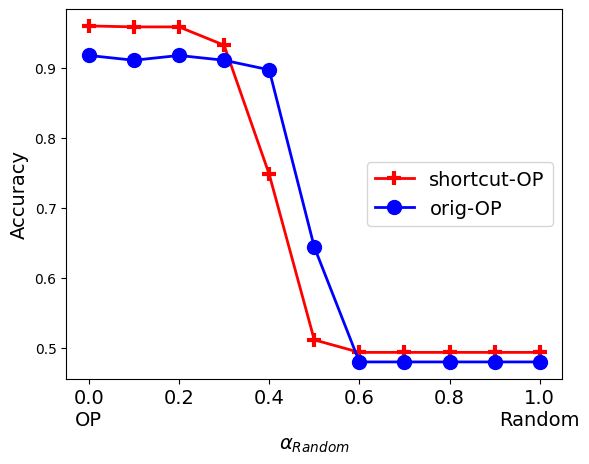

In [6]:
plot_random(op_synth_results, op_orig_results, 'OP')

In [ ]:
results = interpolate_and_evaluate_2d('sst2', or_model, random_model, tokenizer, [or_dataset_path])
or_synth_results, or_orig_results = results[or_dataset_path]['synthetic'], results[or_dataset_path]['original']

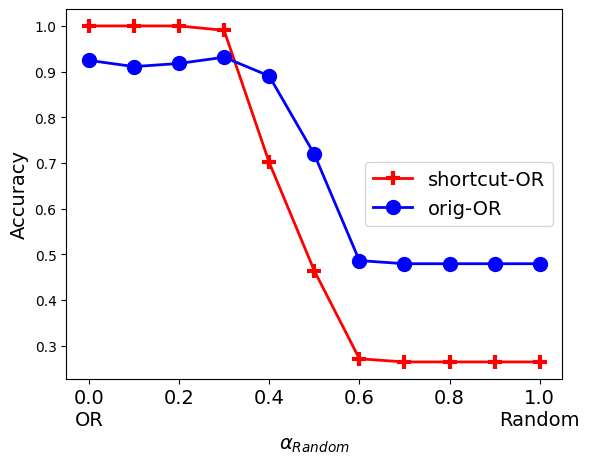

In [8]:
plot_random(or_synth_results, or_orig_results, 'OR')

In [ ]:
results = interpolate_and_evaluate_2d('sst2', st_model, random_model, tokenizer, [st_dataset_path])
st_synth_results, st_orig_results = results[st_dataset_path]['synthetic'], results[st_dataset_path]['original']

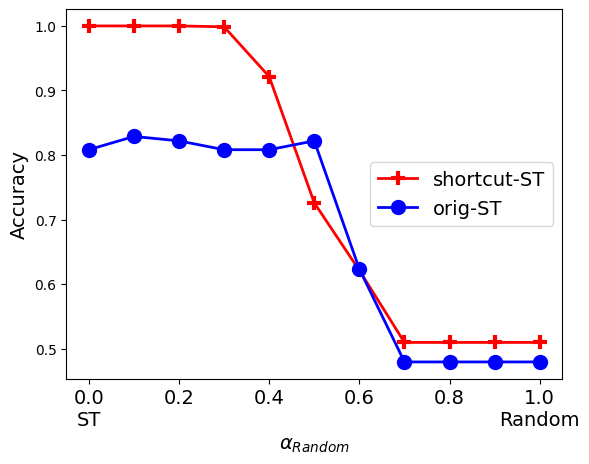

In [10]:
plot_random(st_synth_results, st_orig_results, 'ST')

In [ ]:
results = interpolate_and_evaluate_2d('sst2', tic_model, random_model, tokenizer, [tic_dataset_path])
tic_synth_results, tic_orig_results = results[tic_dataset_path]['synthetic'], results[tic_dataset_path]['original']

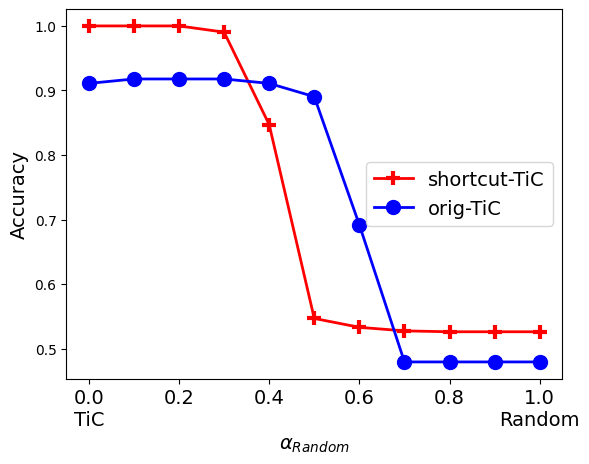

In [12]:
plot_random(tic_synth_results, tic_orig_results, 'TiC')

## Plot all fusion performance

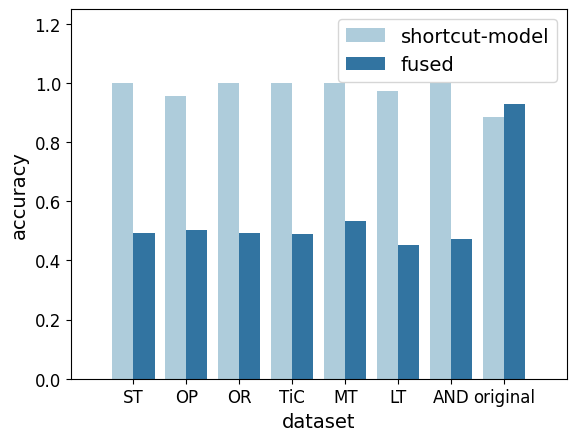

In [13]:
import seaborn as sns
import json
import numpy as np
import pandas as pd

with open('results/fusion_results.json', 'r') as f:
    data = json.load(f)

res, fused_res = data['results_on_their_datasets'], data['fused_results_on_other_datasets']
datasets = list(res.keys()) + ['original']

plot_data = []
for model_type in ['shortcut-model', 'fused']:
    for dataset in datasets:
        if model_type == 'shortcut-model':
            plot_res = res
        elif model_type == 'fused':
            plot_res = fused_res
        
        if dataset == 'original':
            accuracy = np.average(list(map(lambda x: plot_res[x]['original'], plot_res.keys())))
        else:
            accuracy = plot_res[dataset]['synthetic']
        
        plot_data.append({'model': model_type, 'dataset': dataset, 'accuracy': accuracy})

df = pd.DataFrame.from_dict(plot_data)

ax = sns.barplot(data=df, x='dataset', y='accuracy', hue='model', palette="Paired")
ax.legend_.set_title(None)
plt.legend(fontsize=14)
ax.margins(x=0.1, y=0.25)

#ax.axes.set_title("Title",fontsize=50)
ax.set_xlabel("dataset",fontsize=14)
ax.set_ylabel("accuracy",fontsize=14)
ax.tick_params(labelsize=12)

fig = ax.get_figure()
fig.savefig("fusion_results.png", dpi=400, bbox_inches='tight') 